# Useful links

- [ ] https://cran.r-project.org/web/packages/afex/vignettes/introduction-mixed-models.pdf
- [ ] https://cran.r-project.org/web/packages/afex/afex.pdf
- [ ] https://cran.r-project.org/web/packages/afex/index.html
- [ ] https://cran.r-project.org/web/packages/afex/vignettes/afex_analysing_accuracy_data.html
- [ ] https://cran.r-project.org/web/packages/afex/vignettes/afex_anova_example.html
- [ ] https://cran.r-project.org/web/packages/afex/vignettes/afex_mixed_example.html
- [ ] https://cran.r-project.org/web/packages/emmeans/vignettes/comparisons.html
- [ ] https://cran.r-project.org/web/packages/emmeans/vignettes/messy-data.html
- [ ] https://cran.r-project.org/web/packages/emmeans/vignettes/interactions.html
- [ ] https://cran.r-project.org/web/packages/emmeans/vignettes/basics.html
- [ ] https://cran.r-project.org/web/packages/afex/vignettes/afex_mixed_example.html

- [ ] https://osf.io/nfwx7/

- [ ] https://stats.stackexchange.com/questions/13166/rs-lmer-cheat-sheet

- [ ] https://psu-psychology.github.io/r-bootcamp-2018/index.html
- [ ] http://tysonbarrett.com/EDUC-6600/Resources/Example_Ch15_rmANOVA.html
- [ ] http://singmann.org/anova-in-r-afex-may-be-the-solution-you-are-looking-for/
- [ ] https://ademos.people.uic.edu/Chapter21.html
- [ ] https://www.psychologie.uni-heidelberg.de/ae/meth/team/mertens/blog/anova_in_r_made_easy.nb.html
- [ ] http://tysonbarrett.com/EDUC-6600/Resources/Example_Ch15_rmANOVA.html

# Setup

## Imports

In [1]:
library("dplyr")
library("tidyr")
library("afex")     # provides mixed() and attaches lme4 automatically.
library("emmeans")  # follow-up tests.
library("multcomp") # advanced control for multiple testing/Type 1 errors.
library("ggplot2")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global pac

In [2]:
library("car")
require("lattice")
require("ez")

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Loading required package: lattice

Loading required package: ez



In [3]:
library("cowplot")
library("ggbeeswarm")

In [4]:
library("nortest")

## Settings

In [5]:
theme_set(theme_bw(base_size = 15) +
            theme(legend.position="bottom",
                  panel.grid.major.x = element_blank()))

In [6]:
options(width=120)

## Info

In [7]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_IL.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_IL.UTF-8    LC_MESSAGES=en_US.UTF-8    LC_PAPER=en_IL.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C             LC_MEASUREMENT=en_IL.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] nortest_1.0-4    ggbeeswarm_0.6.0 cowplot_1.1.0    ez_4.4-0         lattice_0.20-41  car_3.0-10      
 [7] carData_3.0-4    ggplot2_3.3.2    multcomp_1.4-14  TH.data_1.0-10   MASS_7.3-53      survival_3.2-7  
[13] mvtnorm_1.1-1    emmeans_1.5.1    afex_0.28-0      lme4_1.1-23    

# Create output directory

In [8]:
dir.create("data/t1007",showWarnings = FALSE,recursive = TRUE)

## Handy functions

### Function for logging information BEFORE execution

In [9]:
logging0 <- function(ifName,infoStr="",data){
    t0 <- Sys.time()
    s0 <- gsub("\\s","_",t0)
    s1 <- gsub("^.","",tempfile("","",""))
    s2 <- gsub("/t1006/","/t1007/",ifName)
    ofName <- paste(paste(s2,"",s0,"",s1,infoStr,"_nrow",nrow(data),sep="_"),".RData",sep="")
    lfName = paste(ofName ,".LOG.txt" ,sep="" ,collapse = "")
    log_msg <- toString(paste(
        paste("logs0" ,toString(lfName)     ,sep=": " ,collapse = "")
      , paste("time0" ,toString(Sys.time()) ,sep=": " ,collapse = "")
      , paste("nrows" ,toString(nrow(data))  ,sep=": " ,collapse = "")
      , paste("ncols" ,toString(ncol(data))  ,sep=": " ,collapse = "")
      , paste("vList" ,toString(ls())       ,sep=": " ,collapse = "")
      , paste("oSave" ,toString(ofName)     ,sep=": " ,collapse = "")        
      , "\n"
      , sep="\n"))
    cat(log_msg)
    write(paste(log_msg) ,file=lfName ,append=TRUE)
    return(list("ofName"=ofName,"lfName"=lfName,"t0"=t0))
}

### Function for logging information AFTER execution

In [10]:
logging1 <- function(lfName,t0){
    t1 <- Sys.time()
    d1 <- t1-t0
    log_msg <- toString(paste(
        paste("time1" ,toString(Sys.time()) ,sep=": " ,collapse = "")
      , paste("diff1" ,capture.output(d1)   ,sep=": " ,collapse = "")
      , "\n"
      , sep="\n"))
    cat(log_msg)
    write(paste(log_msg) ,file=lfName ,append=TRUE)
    return(list("d1" = d1))
}

# Load data

Depending on how much data you want to include select a file to be loaded (either by executing relevant cell or by clicking ↑ or ↓ above to move cells up or down, the last executed cell containing `ifName` defines the file to be loaded).

In [11]:
ifName="data/t1006/bigDF__df2__001_unstacked.RData" # 752554 obs

In [12]:
load(file=ifName)

# Quick look at data

In [13]:
str(df2)

'data.frame':	752554 obs. of  20 variables:
 $ CAMP       : Factor w/ 2 levels "metoo","sexstrike": 1 1 1 1 1 1 1 1 1 1 ...
 $ TYPE       : Factor w/ 2 levels "ctrl","orig": 1 1 1 1 1 1 1 1 1 1 ...
 $ wordCnt    : num  11 7 11 27 30 26 8 12 12 23 ...
 $ vb01Cnt    : num  0 0 0 2 0 0 1 0 1 0 ...
 $ nn01Cnt    : num  1 2 0 2 3 4 1 4 1 4 ...
 $ ag01Cnt    : num  0 0 0 0 1 1 0 0 1 2 ...
 $ ag02Cnt    : num  0 0 0 0 1 0 0 0 1 0 ...
 $ vb01Prc    : num  0 0 0 0.0741 0 ...
 $ nn01Prc    : num  0.0909 0.2857 0 0.0741 0.1 ...
 $ ag01Prc    : num  0 0 0 0 0.0333 ...
 $ ag02Prc    : num  0 0 0 0 0.0333 ...
 $ ID         : chr  "919714354467045376" "919714354479722496" "919714354500653056" "919714354542600192" ...
 $ tweet_url  : chr  "/IamJonesy3/status/919714354467045376" "/CCmee_/status/919714354479722496" "/SarahJaneVlogs/status/919714354500653057" "/queentyreen/status/919714354542600195" ...
 $ user_id    : chr  "588400632" "242582835" "29298715" "3290716455" ...
 $ is_replied : logi  TRUE FA

In [14]:
summary(df2)

        CAMP          TYPE           wordCnt          vb01Cnt           nn01Cnt          ag01Cnt       
 metoo    :676038   ctrl:413976   Min.   :  1.00   Min.   : 0.0000   Min.   : 0.000   Min.   : 0.0000  
 sexstrike: 76516   orig:338578   1st Qu.:  9.00   1st Qu.: 0.0000   1st Qu.: 2.000   1st Qu.: 0.0000  
                                  Median : 17.00   Median : 0.0000   Median : 3.000   Median : 0.0000  
                                  Mean   : 16.96   Mean   : 0.7442   Mean   : 3.498   Mean   : 0.6333  
                                  3rd Qu.: 24.00   3rd Qu.: 1.0000   3rd Qu.: 5.000   3rd Qu.: 1.0000  
                                  Max.   :106.00   Max.   :17.0000   Max.   :43.000   Max.   :21.0000  
    ag02Cnt          vb01Prc           nn01Prc          ag01Prc           ag02Prc             ID           
 Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   :0.00000   Min.   :0.00000   Length:752554     
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.1250   1st

In [15]:
df2 %>%
    group_by(CAMP,TYPE) %>%
    summarise(n = n(), .groups = "drop") 

CAMP,TYPE,n
<fct>,<fct>,<int>
metoo,ctrl,369527
metoo,orig,306511
sexstrike,ctrl,44449
sexstrike,orig,32067


# ANOVA (`aov_4`)

| name         | meta   | descr                       |
|--------------|--------|-----------------------------|
| `ID`         | `u1`   | observation unit (tweet_id) |
| `vb01Prc`    | `d1`   | outcome (dependent)         |
| `ag01Prc`    | `d2`   | outcome (dependent)         |
| `CAMP`       | `b1`   | between tweet               |
| `TYPE`       | `b2`   | between tweet               |

In [16]:
OBSERVED <- c("CAMP","TYPE")

In [17]:
OBSERVED <- NULL

In [18]:
FORMULA <- vb01Prc~CAMP*TYPE+(1|ID)

log0 <- logging0(ifName,infoStr="_aov_4_a1vb01Prc",data=df2)
a1vb01Prc <- aov_4(
    formula       <- FORMULA,
    data          <- df2,
    observed      <- OBSERVED,
)
save(a1vb01Prc,file=log0$ofName)
log1 <- logging1(log0$lfName,log0$t0)

logs0: data/t1007/bigDF__df2__001_unstacked.RData__2020-10-07_15:31:09__6aeb1286eb3a__aov_4_a1vb01Prc__nrow_752554.RData.LOG.txt
time0: 2020-10-07 15:31:09
nrows: 752554
ncols: 20
vList: data, ifName, infoStr, lfName, ofName, s0, s1, s2, t0
oSave: data/t1007/bigDF__df2__001_unstacked.RData__2020-10-07_15:31:09__6aeb1286eb3a__aov_4_a1vb01Prc__nrow_752554.RData



Contrasts set to contr.sum for the following variables: CAMP, TYPE



time1: 2020-10-07 15:32:12
diff1: Time difference of 1.046851 mins



In [19]:
FORMULA <- ag01Prc~CAMP*TYPE+(1|ID)

log0 <- logging0(ifName,infoStr="_aov_4_a2ag01Prc",data=df2)
a2ag01Prc <- aov_4(
    formula       <- FORMULA,
    data          <- df2,
    observed      <- OBSERVED,
)
save(a2ag01Prc,file=log0$ofName)
log1 <- logging1(log0$lfName,log0$t0)

logs0: data/t1007/bigDF__df2__001_unstacked.RData__2020-10-07_15:32:12__6aeb227b8cbc__aov_4_a2ag01Prc__nrow_752554.RData.LOG.txt
time0: 2020-10-07 15:32:12
nrows: 752554
ncols: 20
vList: data, ifName, infoStr, lfName, ofName, s0, s1, s2, t0
oSave: data/t1007/bigDF__df2__001_unstacked.RData__2020-10-07_15:32:12__6aeb227b8cbc__aov_4_a2ag01Prc__nrow_752554.RData



Contrasts set to contr.sum for the following variables: CAMP, TYPE



time1: 2020-10-07 15:33:11
diff1: Time difference of 58.53137 secs



# Quick look at AOV results

In [20]:
summary(a1vb01Prc)

,num Df,den Df,MSE,F,ges,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAMP,1,752550,0.00486059,580.81725,7.712037e-04,2.786924e-128
TYPE,1,752550,0.00486059,35.79417,4.756157e-05,2.194022e-09
CAMP:TYPE,1,752550,0.00486059,111.52739,1.481773e-04,4.554075e-26


In [21]:
summary(a2ag01Prc)

,num Df,den Df,MSE,F,ges,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAMP,1,752550,0.004795996,1008.14240,1.337843e-03,4.277606e-221
TYPE,1,752550,0.004795996,54.52086,7.244291e-05,1.539638e-13
CAMP:TYPE,1,752550,0.004795996,385.90723,5.125366e-04,6.768308e-86


# Estimated marginal means (Least-squares means)

## Full model

In [41]:
a1vb01PrcEm1 <- emmeans(a1vb01Prc, specs<-c("CAMP", "TYPE"))
a2ag01PrcEm1 <- emmeans(a2ag01Prc, specs<-c("CAMP", "TYPE"))

In [42]:
a1vb01PrcEm1

 CAMP      TYPE  emmean        SE     df lower.CL upper.CL
 metoo     ctrl 0.04612 0.0001147 752550  0.04590  0.04635
 sexstrike ctrl 0.04977 0.0003307 752550  0.04912  0.05042
 metoo     orig 0.04167 0.0001259 752550  0.04142  0.04191
 sexstrike orig 0.05100 0.0003893 752550  0.05024  0.05176

Confidence level used: 0.95 

In [43]:
a2ag01PrcEm1

 CAMP      TYPE emmean       SE     df lower.CL upper.CL
 metoo     ctrl 0.0409 0.000114 752550   0.0406   0.0411
 sexstrike ctrl 0.0441 0.000328 752550   0.0434   0.0447
 metoo     orig 0.0336 0.000125 752550   0.0334   0.0339
 sexstrike orig 0.0474 0.000387 752550   0.0466   0.0481

Confidence level used: 0.95 

In [44]:
pairs(a1vb01PrcEm1)

 contrast                        estimate       SE     df t.ratio p.value
 metoo ctrl - sexstrike ctrl     -0.00365 0.000350 752550 -10.415 <.0001 
 metoo ctrl - metoo orig          0.00445 0.000170 752550  26.150 <.0001 
 metoo ctrl - sexstrike orig     -0.00488 0.000406 752550 -12.018 <.0001 
 sexstrike ctrl - metoo orig      0.00810 0.000354 752550  22.889 <.0001 
 sexstrike ctrl - sexstrike orig -0.00123 0.000511 752550  -2.413 0.0747 
 metoo orig - sexstrike orig     -0.00933 0.000409 752550 -22.806 <.0001 

P value adjustment: tukey method for comparing a family of 4 estimates 

In [45]:
pairs(a2ag01PrcEm1)

 contrast                        estimate       SE     df t.ratio p.value
 metoo ctrl - sexstrike ctrl     -0.00324 0.000348 752550  -9.313 <.0001 
 metoo ctrl - metoo orig          0.00723 0.000169 752550  42.723 <.0001 
 metoo ctrl - sexstrike orig     -0.00652 0.000403 752550 -16.164 <.0001 
 sexstrike ctrl - metoo orig      0.01047 0.000351 752550  29.776 <.0001 
 sexstrike ctrl - sexstrike orig -0.00328 0.000507 752550  -6.462 <.0001 
 metoo orig - sexstrike orig     -0.01375 0.000406 752550 -33.817 <.0001 

P value adjustment: tukey method for comparing a family of 4 estimates 

In [46]:
TEST=adjusted("bonferroni")

In [47]:
TEST=adjusted("free")

In [48]:
summary(as.glht(pairs(a1vb01PrcEm1)),test=TEST)


	 Simultaneous Tests for General Linear Hypotheses

Linear Hypotheses:
                                       Estimate Std. Error t value Pr(>|t|)    
metoo ctrl - sexstrike ctrl == 0     -0.0036452  0.0003500 -10.415  < 2e-16 ***
metoo ctrl - metoo orig == 0          0.0044540  0.0001703  26.150  < 2e-16 ***
metoo ctrl - sexstrike orig == 0     -0.0048777  0.0004059 -12.018  < 2e-16 ***
sexstrike ctrl - metoo orig == 0      0.0080992  0.0003539  22.889  < 2e-16 ***
sexstrike ctrl - sexstrike orig == 0 -0.0012325  0.0005108  -2.413   0.0158 *  
metoo orig - sexstrike orig == 0     -0.0093317  0.0004092 -22.806 1.33e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- free method)


In [49]:
summary(as.glht(pairs(a2ag01PrcEm1)),test=TEST)


	 Simultaneous Tests for General Linear Hypotheses

Linear Hypotheses:
                                       Estimate Std. Error t value Pr(>|t|)    
metoo ctrl - sexstrike ctrl == 0     -0.0032378  0.0003477  -9.313  < 2e-16 ***
metoo ctrl - metoo orig == 0          0.0072283  0.0001692  42.723  < 2e-16 ***
metoo ctrl - sexstrike orig == 0     -0.0065167  0.0004032 -16.164  < 2e-16 ***
sexstrike ctrl - metoo orig == 0      0.0104661  0.0003515  29.776  < 2e-16 ***
sexstrike ctrl - sexstrike orig == 0 -0.0032789  0.0005074  -6.462 1.03e-10 ***
metoo orig - sexstrike orig == 0     -0.0137450  0.0004065 -33.817  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- free method)


### Contrasts

In [73]:
coef(contrast(a2ag01PrcEm1))

,CAMP,TYPE,c.1,c.2,c.3,c.4
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
metoo ctrl,metoo,ctrl,0.75,-0.25,-0.25,-0.25
sexstrike ctrl,sexstrike,ctrl,-0.25,0.75,-0.25,-0.25
metoo orig,metoo,orig,-0.25,-0.25,0.75,-0.25
sexstrike orig,sexstrike,orig,-0.25,-0.25,-0.25,0.75


In [74]:
coef(contrast(a1vb01PrcEm1))

,CAMP,TYPE,c.1,c.2,c.3,c.4
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
metoo ctrl,metoo,ctrl,0.75,-0.25,-0.25,-0.25
sexstrike ctrl,sexstrike,ctrl,-0.25,0.75,-0.25,-0.25
metoo orig,metoo,orig,-0.25,-0.25,0.75,-0.25
sexstrike orig,sexstrike,orig,-0.25,-0.25,-0.25,0.75


## Effect of TYPE (ctrl, orig) conditional on CAMP (#sexstrike, #metoo)

In [50]:
a1vb01PrcEm2 <- emmeans(a1vb01Prc, specs<-c("TYPE"), by<-"CAMP")
a2ag01PrcEm2 <- emmeans(a2ag01Prc, specs<-c("TYPE"), by<-"CAMP")

In [51]:
a1vb01PrcEm2

CAMP = metoo:
 TYPE  emmean        SE     df lower.CL upper.CL
 ctrl 0.04612 0.0001147 752550  0.04590  0.04635
 orig 0.04167 0.0001259 752550  0.04142  0.04191

CAMP = sexstrike:
 TYPE  emmean        SE     df lower.CL upper.CL
 ctrl 0.04977 0.0003307 752550  0.04912  0.05042
 orig 0.05100 0.0003893 752550  0.05024  0.05176

Confidence level used: 0.95 

In [52]:
a2ag01PrcEm2

CAMP = metoo:
 TYPE emmean       SE     df lower.CL upper.CL
 ctrl 0.0409 0.000114 752550   0.0406   0.0411
 orig 0.0336 0.000125 752550   0.0334   0.0339

CAMP = sexstrike:
 TYPE emmean       SE     df lower.CL upper.CL
 ctrl 0.0441 0.000328 752550   0.0434   0.0447
 orig 0.0474 0.000387 752550   0.0466   0.0481

Confidence level used: 0.95 

In [53]:
pairs(a1vb01PrcEm2)

CAMP = metoo:
 contrast    estimate       SE     df t.ratio p.value
 ctrl - orig  0.00445 0.000170 752550 26.150  <.0001 

CAMP = sexstrike:
 contrast    estimate       SE     df t.ratio p.value
 ctrl - orig -0.00123 0.000511 752550 -2.413  0.0158 


In [54]:
pairs(a2ag01PrcEm2)

CAMP = metoo:
 contrast    estimate       SE     df t.ratio p.value
 ctrl - orig  0.00723 0.000169 752550 42.723  <.0001 

CAMP = sexstrike:
 contrast    estimate       SE     df t.ratio p.value
 ctrl - orig -0.00328 0.000507 752550 -6.462  <.0001 


In [57]:
summary(as.glht(pairs(a1vb01PrcEm2)),test=TEST)

$`CAMP = metoo`

	 Simultaneous Tests for General Linear Hypotheses

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)    
ctrl - orig == 0 0.0044540  0.0001703   26.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- free method)


$`CAMP = sexstrike`

	 Simultaneous Tests for General Linear Hypotheses

Linear Hypotheses:
                   Estimate Std. Error t value Pr(>|t|)  
ctrl - orig == 0 -0.0012325  0.0005108  -2.413   0.0158 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- free method)



In [56]:
summary(as.glht(pairs(a2ag01PrcEm2)),test=TEST)

$`CAMP = metoo`

	 Simultaneous Tests for General Linear Hypotheses

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)    
ctrl - orig == 0 0.0072283  0.0001692   42.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- free method)


$`CAMP = sexstrike`

	 Simultaneous Tests for General Linear Hypotheses

Linear Hypotheses:
                   Estimate Std. Error t value Pr(>|t|)    
ctrl - orig == 0 -0.0032789  0.0005074  -6.462 1.03e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- free method)



# Handy plots

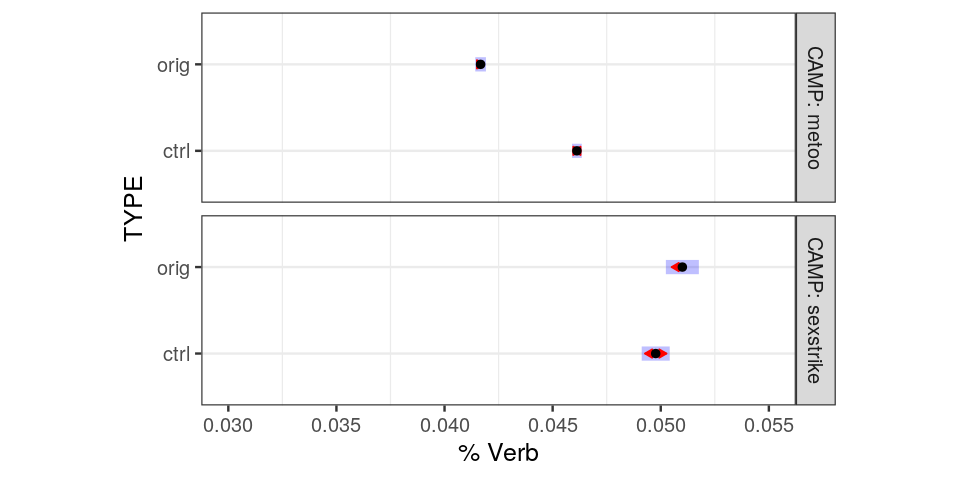

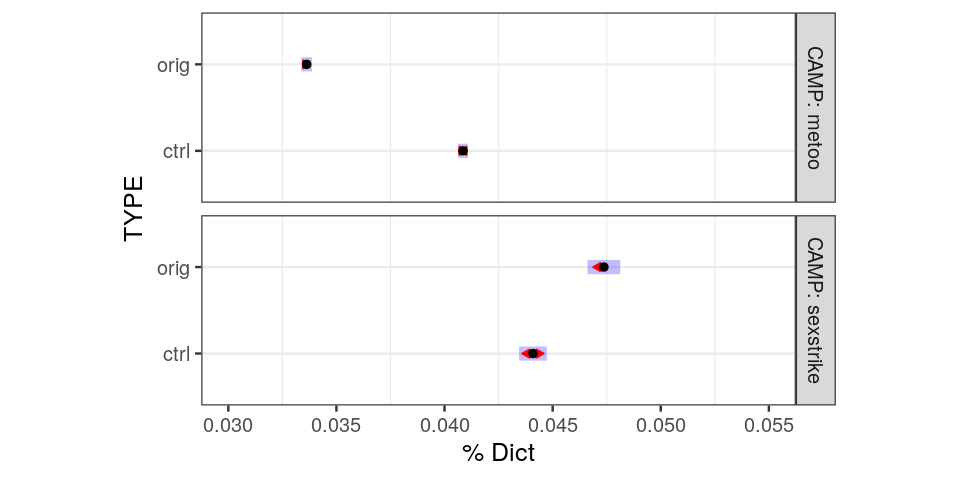

In [174]:
library(repr)
options(repr.plot.width=8, repr.plot.height=4)
fig.height = 10
fig.width = 5
plot(a1vb01PrcEm2, comparisons=TRUE, xlab="% Verb")+
coord_fixed(ratio = 0.004,xlim=c(0.030, 0.055),ylim=NULL,expand=TRUE,clip="on")
#+ 
#  theme(
#      plot.margin = margin(.2,.2,.2,.2, "cm"),
#      plot.background = element_rect(fill = "darkgrey")
#  )

plot(a2ag01PrcEm2, comparisons=TRUE, xlab="% Dict")+
coord_fixed(ratio = 0.004,xlim=c(0.030, 0.055),ylim=NULL,expand=TRUE,clip="on")


In [179]:
#                      ___           ___                    ___           ___                   
#                     /\  \         /\__\                  /\__\         /\  \         _____    
#        ___          \:\  \       /:/ _/_                /:/ _/_        \:\  \       /::\  \   
#       /\__\          \:\  \     /:/ /\__\              /:/ /\__\        \:\  \     /:/\:\  \  
#      /:/  /      ___ /::\  \   /:/ /:/ _/_            /:/ /:/ _/_   _____\:\  \   /:/  \:\__\ 
#     /:/__/      /\  /:/\:\__\ /:/_/:/ /\__\          /:/_/:/ /\__\ /::::::::\__\ /:/__/ \:|__|
#    /::\  \      \:\/:/  \/__/ \:\/:/ /:/  /          \:\/:/ /:/  / \:\~~\~~\/__/ \:\  \ /:/  /
#   /:/\:\  \      \::/__/       \::/_/:/  /            \::/_/:/  /   \:\  \        \:\  /:/  / 
#   \/__\:\  \      \:\  \        \:\/:/  /              \:\/:/  /     \:\  \        \:\/:/  /  
#        \:\__\      \:\__\        \::/  /                \::/  /       \:\__\        \::/  /   
#         \/__/       \/__/         \/__/                  \/__/         \/__/         \/__/    
#  




# Helpers

In [29]:
?mixed

In [ ]:
?scale

In [ ]:
?lmer

In [ ]:
?aov_4

In [ ]:
?emmeans

In [157]:
?coord_fixed

# Extras

In [ ]:
df2$retweets <- as.numeric(df2$retweets) # TODO FIXME This should be fixed elsewhere!

In [ ]:
df2$ReTw <- cut(df2$retweets,
                breaks=c(0, 5, 25, 125, Inf), 
                right  = FALSE,
              # labels=c("low","med","high","viral")
               )

str(df2)

# Playground

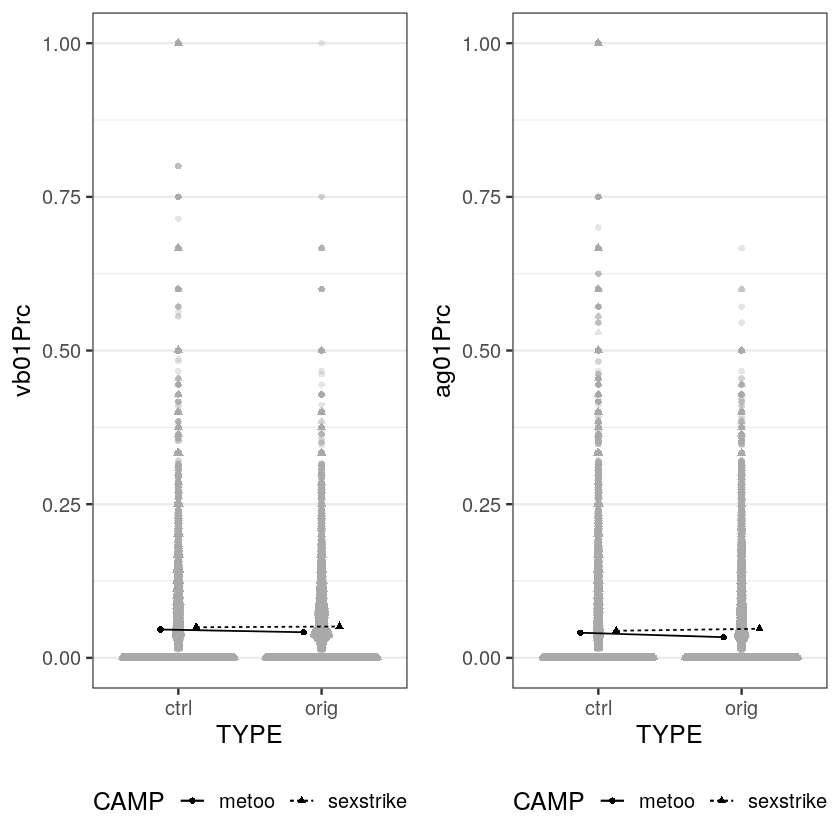

In [116]:
plot_grid(
  afex_plot(
      a1vb01Prc, 
      x="TYPE", 
      trace="CAMP",
      error = "between", 
      data_geom = geom_quasirandom, 
      data_alpha = 0.3) + 
    coord_cartesian(ylim = c(0, 1)),
  afex_plot(
      a2ag01Prc, 
      x="TYPE", 
      trace="CAMP",
      error = "between", 
      data_geom = geom_quasirandom, 
      data_alpha = 0.3) +
    coord_cartesian(ylim = c(0, 1))
)

[1] 203080  84312

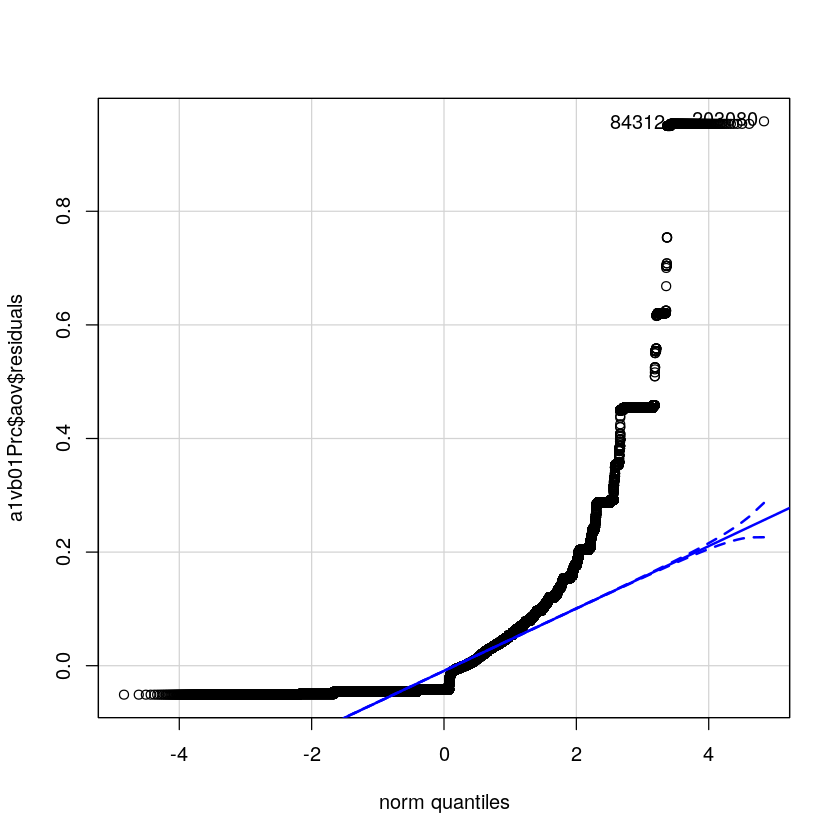

In [118]:
qqPlot(a1vb01Prc$aov$residuals)

[1] 86914 88015

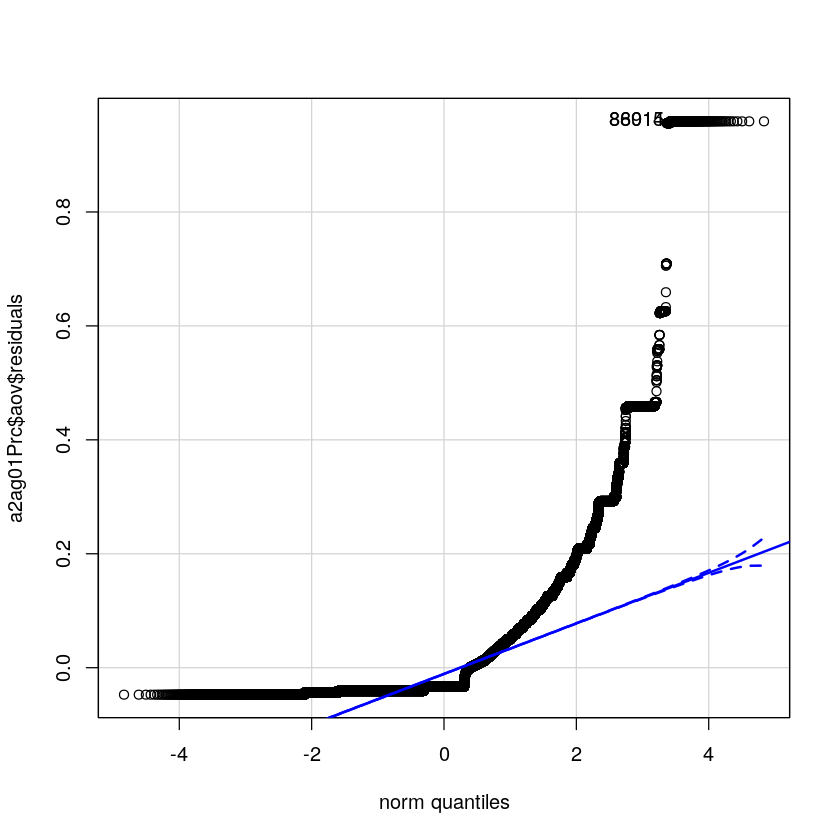

In [119]:
qqPlot(a2ag01Prc$aov$residuals)

In [120]:
shapiro.test(a1vb01Prc$aov$residuals)

ERROR: Error in shapiro.test(a1vb01Prc$aov$residuals): sample size must be between 3 and 5000


In [ ]:
shapiro.test(a2ag01Prc$aov$residuals)

In [ ]:
ad.test(a1vb01Prc$aov$residuals)$p.value

In [ ]:
ad.test(a2ag01Prc$aov$residuals)$p.value

In [ ]:
test_levene(a1vb01Prc)

In [ ]:
test_levene(a2ag01Prc)

In [177]:
library("pwr")

In [27]:
?pwr.anova.test

In [30]:
?summary